# INSPIRED BY:

## [Distributed Cohesive Control for Robot Swarms: Maintaining Good Connectivity in the Presence of Exterior Forces][title]

#### by D. Krupke, M. Ernestus, M. Hemmer, and S.P. Fekete

Published in: IEEE/RSJ IROS 2015 - DOI: 10.1109/IROS.2015.7353406

>We present a number of powerful local mechanisms for maintaining a dynamic swarm of robots with limited capabilities and information, in the presence of external forces and permanent node failures. We propose a set of local continuous algorithms that together produce a generalization of a Euclidean Steiner tree. At any stage, the resulting overall shape achieves a good compromise between local thickness, global connectivity, and flexibility to further continuous motion of the terminals. The resulting swarm behavior scales well, is robust against node failures, and performs close to the best known approximation bound for a corresponding centralized static optimization problem.

[title]:http://ieeexplore.ieee.org/xpls/abs_all.jsp?arnumber=7353406

In [95]:
%matplotlib inline

In [96]:
from matplotlib import animation, rc
from IPython.display import HTML
import matplotlib.pyplot as plt
import numpy as np
import os
import math
import random
random.seed(a=None, version=2)

## Parameters

- $N$ is the number of robots
- $L$ is the number of leaders (randomly chosen among the robots)
- $T$ is the number of tasks/targets
- $D$ is the length of the side of the square arena, in meters
- $H$ is the length of the time horizon of the simulation, in seconds
- $control$ is the period (in s) used by the robots/simulation to recompute the robots' velocities and positions
- $propagation$ is the period (in s) at which the robots/simulation broadcast messages to neighbors
- $maxspeed$ is the maximum linear speed of a robot in meters per second
- $radius$ is how far a robot can detect another robot, in meters
- $plot\_sampling$ defines how often the simulation is plotted (in s)

In [97]:
###########
#parameters
###########

N = 15             #number of robots
L = 4              #number of leaders
T = 5              #number of tasks
D = 8              #size of the arena (in m)
H = 600            #time horizon (in s)
control = 0.5      #time step of the control, i.e. recomputation of the velocity vectors (in s)
propagation = 0.02 #time step of the communication, i.e. broadcast of messages to neighbors (in s)
maxspeed = 0.03    #max linear speed of a robot (in m/s)
radius = 1.0       #range of visibility (in m)
plot_sampling = 3  #how often plots are produced (in s)


################
#data structures
################

leaders = np.zeros(N)          #binary vector identifying the leaders, initialized with 0s
leaders_ids = np.zeros(L)      #vector identifying the leaders by id, initialized with 0s
positions = np.zeros((N, 2))   #matrix whose rows contain the x,y of each robot, initialized with 0s
velocities = np.zeros((N, 2))  #matrix whose rows contain the x',y' of each robot, initialized with 0s
tasks = np.zeros((T, 2))       #matrix whose rows contain the x,y of each target, initialized with 0s
mapping = np.zeros((L, 2))

#swarm's knowledge base
boundaries = np.zeros((N, 3))      #matrix whose rows contain a BOOL and the IDs of the 2 other boundary neighbors
lknowledge = np.zeros((N, L*5))    #matrix whose rows contain what each robot knows about the leaders (pos, v, tstamp)
#tknowledge = np.zeros((N, T*3))   #matrix whose rows contain what each robot knows about the targets (pos, tstamp)
thickness_info = np.zeros((N, 3))  #matrix containing the b, t, and h heuristic metrics of each robot

### init()
init() randomly assigns the leader role to $L$ robots, (uniformly) randomly places the tasks in the arena, and the robots in a circle in the center of the arena.
- input: _none_
- output: _none_

In [98]:
def init():
    s = 0
    while s < L:                           #initialize the leaders vector
        robot = random.randint(0,N-1)      #random integer between 0 and 9
        if (leaders[robot] == 0):
            leaders[robot] = 1
            leaders_ids[s] = robot
            s = s + 1

    for i in range(0,N):
        positions[i,0] = (D/2) + (D/4)*(random.random()-1/2)
        positions[i,1] = (D/2) + (D/4)*(random.random()-1/2)

    for i in range(0,T):
        tasks[i,0] = 0.05*D + 0.9*D*random.random()
        tasks[i,1] = 0.05*D + 0.9*D*random.random()

### neighbors()
neighbors() computes the adjacency matrix A of the swarm, using the value of $radius$
- input: _none_
- output: __A__

In [99]:
def neighbors():
    A = np.zeros((N,N))         #adjacency matrix, initialized with 0s
    for i in range(0,N):
        for j in range(0,N):
            if ( (positions[i,0]-positions[j,0])**2 + (positions[i,1]-positions[j,1])**2 ) < (radius)**2:
                A[i,j] = 1
    return A

### leaderstotargets()
leaderstotargets() directs the $L$ leaders to the nearest target (currently using a greedy implementation)
- input: _none_
- output: _none_

In [100]:
def l_mapping():
    distLtoT = np.zeros((L, T + 1))
    for i in range(0,T):
        count = 0
        for j in range(0,N):
            if leaders[j]==1:
                if i==0:
                    distLtoT[count,0] = j
                distLtoT[count,i+1] = math.sqrt((tasks[i,0]-positions[j,0])**2+(tasks[i,1]-positions[j,1])**2)
                count = count + 1
    
    ###############
    #greedy mapping
    ###############
    for i in range(0,L):
        mapping[i,0] = -1
        mapping[i,1] = -1
        
    assigned = 0
    while assigned<L:
        min_d=2*D
        for i in range(0,L):
            
            leader_already_assigned = 0
            for j in range(0,L):
                if mapping[j,0] == distLtoT[i,0]:
                    leader_already_assigned = 1
            if leader_already_assigned==1:
                continue
                
            for j in range(0,T):
                
                target_already_assigned = 0
                for k in range(0,L):
                    if mapping[k,1] == j:
                        target_already_assigned = 1
                if target_already_assigned==1:
                    continue
                    
                if distLtoT[i,j+1]<min_d:
                    min_d = distLtoT[i,j+1]
                    min_l = distLtoT[i,0]
                    min_t = j
                    
        mapping[assigned,0] = min_l
        mapping[assigned,1] = min_t
        assigned = assigned + 1

def leaderstotargets(): 
    for i in range(0,L):
        l_index = int(mapping[i,0])
        t_index = int(mapping[i,1])
        velocities[l_index,0] = tasks[t_index,0] - positions[l_index,0]
        velocities[l_index,1] = tasks[t_index,1] - positions[l_index,1]
        
        norm = math.sqrt(velocities[l_index,0]**2 + velocities[l_index,1]**2)
        if norm != 0:
            velocities[l_index,0] = (velocities[l_index,0]*0.33*maxspeed)/norm
            velocities[l_index,1] = (velocities[l_index,1]*0.33*maxspeed)/norm
        norm = 0                                                                 #safeguard for following iterations

### communicate()
communicate() updates
- input: _none_
- output: _none_

In [101]:
def communicate(a,t):
    A = a
    for i in range(0,N):
            for j in range(0,L):
                l_id = int(leaders_ids[j])
                d_x = positions[l_id,0]-positions[i,0]
                d_y = positions[l_id,1]-positions[i,1]
                dist = math.sqrt(d_x**2+d_y**2)
                if dist < radius:
                    lknowledge[i,(5*j)] = positions[l_id,0]
                    lknowledge[i,(5*j)+1] = positions[l_id,1]
                    lknowledge[i,(5*j)+2] = velocities[l_id,0]
                    lknowledge[i,(5*j)+3] = velocities[l_id,1]
                    lknowledge[i,(5*j)+4] = t
            for j in range(0,N):
                if A[i,j]==1 and i!=j:
                    for k in range(0,L):
                        if lknowledge[i,(5*k)+4]<lknowledge[j,(5*k)+4]:
                            lknowledge[i,(5*k)] = lknowledge[j,(5*k)]
                            lknowledge[i,(5*k)+1] = lknowledge[j,(5*k+1)]
                            lknowledge[i,(5*k)+2] = lknowledge[j,(5*k+2)]
                            lknowledge[i,(5*k)+3] = lknowledge[j,(5*k+3)]
                            lknowledge[i,(5*k)+4] = lknowledge[j,(5*k+4)]                  

### update_thickness_info()
update_thickness_info() updates
- input: _none_
- output: _none_

In [102]:
def update_thickness_info(a):
    A = a
    for i in range(0,N):
        #b
        if boundaries[i,0]==1:
            thickness_info[i,0] = 0
        else:
            thickness_info[i,0] = N
            for j in range(0,N):
                if j!=i and A[i,j]==1 and (thickness_info[j,0]+1)<thickness_info[i,0]:
                    thickness_info[i,0] = thickness_info[j,0]+1
                   
        #t
        lamb = 2
        thickness_info[i,1] = thickness_info[i,0]
        for j in range(0,N):
            if j!=i and A[i,j]==1 and thickness_info[j,1]>thickness_info[i,1]:
                if thickness_info[j,1]+lamb>=thickness_info[j,2]: #extra constraint to deal with irregular boundaries
                    thickness_info[i,1] = thickness_info[j,1]
                    
        #h
        if thickness_info[i,0]==thickness_info[i,1]:
            thickness_info[i,2] = 0
        else:
            thickness_info[i,2] = N
            for j in range(0,N):
                if j!=i and A[i,j]==1 and thickness_info[j,1]==thickness_info[i,1] and (thickness_info[j,2]+1)<thickness_info[i,2]:
                    thickness_info[i,2] = thickness_info[j,2]+1

## Base Behavior

- Flocking algoritm, from [Olfati-Saber (2006)][os2006], _stateless_ and only require information coming from direct neighbors
    1. attraction to neighbors
    2. repulsion from __too close__ neighbors
    3. adaption to neighbors' velocities

$\forall r \in R \qquad \Delta v^{BB(i)}_r = \sum \dots$

_additional forces_ are mentioned in the paper but not better specified

***

- Boundary detection, from [McLurkin and Demaine (2009)][md2009]
    1. determine if a robot lies on the boundary
    2. detect and ignore small holes

$\forall r \in R \qquad \Delta v^{BB(ii)}_r = \sum \dots$

***

- Boundary tension, from [Lee and McLurkin (2014)][lm2014]

$\forall r \in R \qquad \Delta v^{BB(iii)}_r = \sum \dots$


[os2006]:http://ieeexplore.ieee.org/xpl/login.jsp?tp=&arnumber=1605401
[md2009]:http://ieeexplore.ieee.org/xpls/abs_all.jsp?arnumber=5354296
[lm2014]:http://ieeexplore.ieee.org/xpl/login.jsp?tp=&arnumber=6942704

In [103]:
##############
#base behavior
##############

#flocking algorithm
def bb_i(a,ov):
    A = a
    oldvelocities = ov
    for i in range(0,N):
        if leaders[i]==0:
            norm_v = np.zeros(2)
            norm = math.sqrt(oldvelocities[i,0]**2 + oldvelocities[i,1]**2)
            if norm != 0:
                norm_v[0] = oldvelocities[i,0]/norm
                norm_v[1] = oldvelocities[i,1]/norm
            norm_rep_from_n = np.zeros(2)
            norm_attr_to_n = np.zeros(2)
            norm_v_of_n = np.zeros(2)
            for j in range(0,N):
                if A[i,j] == 1 and i!=j:
                    distance_x = positions[j,0]-positions[i,0]
                    distance_y = positions[j,1]-positions[i,1]
                    d = math.sqrt(distance_x**2 + distance_y**2)
                    #repulsion from too close neighbors (disregarding their absolute distance)
                    repel_to_attract_ratio = 0.5
                    if d==0: #special case for identically positioned robots
                        norm_rep_from_n[0] = norm_rep_from_n[0] + random.random()
                        norm_rep_from_n[1] = norm_rep_from_n[1] + random.random()
                    elif (d>0 and d<(radius*repel_to_attract_ratio)):
                        norm_rep_from_n[0] = norm_rep_from_n[0] + distance_x
                        norm_rep_from_n[1] = norm_rep_from_n[1] + distance_y

                    #attraction to neighbors (proportional to their absolute distance)
                    elif (d>=(radius*repel_to_attract_ratio) and d<radius):
                        if d != 0:
                            norm_x = distance_x/d
                            norm_y = distance_y/d
                        else:
                            norm_x = 0
                            norm_y = 0
                        norm_attr_to_n[0] = norm_attr_to_n[0] + norm_x
                        norm_attr_to_n[1] = norm_attr_to_n[1] + norm_y
                    else:
                        print("Error in bb_i")

                    #adaption to neighbors' velocity
                    norm = math.sqrt(oldvelocities[j,0]**2 + oldvelocities[j,1]**2)
                    if norm != 0:
                        norm_v_of_n[0] = norm_v_of_n[0] + oldvelocities[j,0]/norm
                        norm_v_of_n[1] = norm_v_of_n[1] + oldvelocities[j,1]/norm

            #normalize the 3 directions of contribution
            norm = math.sqrt(norm_rep_from_n[0]**2 + norm_rep_from_n[1]**2)
            if norm != 0:
                norm_rep_from_n[0] = norm_rep_from_n[0]/norm
                norm_rep_from_n[1] = norm_rep_from_n[1]/norm

            norm = math.sqrt(norm_attr_to_n[0]**2 + norm_attr_to_n[1]**2)
            if norm != 0:
                norm_attr_to_n[0] = norm_attr_to_n[0]/norm
                norm_attr_to_n[1] = norm_attr_to_n[1]/norm

            norm = math.sqrt(norm_v_of_n[0]**2 + norm_v_of_n[1]**2)
            if norm != 0:
                norm_v_of_n[0] = norm_v_of_n[0]/norm
                norm_v_of_n[1] = norm_v_of_n[1]/norm

            al = 1.0
            be = 30.0
            ga = 5.0
            de = 5.0
            velocities[i,0]=al*norm_v[0]-be*norm_rep_from_n[0]+ga*norm_attr_to_n[0]+de*norm_v_of_n[0]
            velocities[i,1]=al*norm_v[1]-be*norm_rep_from_n[1]+ga*norm_attr_to_n[1]+de*norm_v_of_n[1]

            norm = math.sqrt(velocities[i,0]**2 + velocities[i,1]**2)
            if norm != 0:
                velocities[i,0] = (velocities[i,0]*maxspeed)/norm
                velocities[i,1] = (velocities[i,1]*maxspeed)/norm
            norm = 0                                                                 #safeguard for following iterations

        

#boundary detection (does not directly affect velocities)
def bb_ii(a):
    A = a
    for i in range(0,N):
        
        #reset boundaries
        boundaries[i,0] = 0
        boundaries[i,1] = -1
        boundaries[i,2] = -1
        
        neighbors = 0
        first_neighbor = -1
        second_neighbor = -1
        poses = np.zeros((N, 5)) #id (-1 if non-neighbor), delta x, delta y, distance, theta
        for j in range(0,N):
            if A[i,j] == 1 and i!=j:
                neighbors = neighbors + 1
                if first_neighbor == -1:
                    first_neighbor = j
                elif second_neighbor == -1:
                    second_neighbor = j
                poses[j,0] = j
                poses[j,1] = positions[j,0]-positions[i,0]
                poses[j,2] = positions[j,1]-positions[i,1]
                poses[j,3] = math.sqrt(poses[j,1]**2 + poses[j,2]**2)
                poses[j,4] = math.atan2(poses[j,2], poses[j,1]) + math.pi
            else:
                poses[j,0] = -1
        sorted_poses = poses[poses[:,4].argsort()] 
        if neighbors == 0 or neighbors == 1 or neighbors == 2:
            boundaries[i,0] = 1
            boundaries[i,1] = first_neighbor
            boundaries[i,2] = second_neighbor
        else:
            for j in range(0,N):
                if sorted_poses[j,0] != -1:
                    next_neighbor_pose = -1
                    for k in range(1,N):
                        pose_index = (j+k)%N
                        if sorted_poses[pose_index,0] != -1:
                            next_neighbor_pose = pose_index
                            break
                    intern_x = positions[int(sorted_poses[next_neighbor_pose,0]),0]-positions[int(sorted_poses[j,0]),0]
                    intern_y = positions[int(sorted_poses[next_neighbor_pose,0]),1]-positions[int(sorted_poses[j,0]),1]
                    interneighbors_d = math.sqrt(intern_x**2 + intern_y**2)
                    interneighbors_theta = sorted_poses[next_neighbor_pose,4]-sorted_poses[j,4]
                    if next_neighbor_pose < j:
                        interneighbors_theta = 2*math.pi+interneighbors_theta
                    if (interneighbors_theta>= math.pi):
                        boundaries[i,0] = 1
                        boundaries[i,1] = int(sorted_poses[j,0])
                        boundaries[i,2] = int(sorted_poses[next_neighbor_pose,0])
                        break
                    elif interneighbors_d > radius:
                        boundaries[i,0] = 1
                        boundaries[i,1] = int(sorted_poses[j,0])
                        boundaries[i,2] = int(sorted_poses[next_neighbor_pose,0])
                        break
                    #FURTHER DEVELOPMENT: COUNT MISSING INFERRED ARCS TO IDENTIFY ARTICULATION POINTS

        
#boundary tension
def bb_iii():
    for i in range(0,N):
        if boundaries[i,0] == 1 and leaders[i]==0:
            if boundaries[i,1] != -1 and boundaries[i,2] != -1:
                
                #vector from i to the midpoint of the boundary neighbors
                mid_x = (positions[int(boundaries[i,1]),0]+positions[int(boundaries[i,2]),0])/2-positions[i,0]
                mid_y = (positions[int(boundaries[i,1]),1]+positions[int(boundaries[i,2]),1])/2-positions[i,1]
                mid_d = math.sqrt(mid_x**2 + mid_y**2)
                norm_x = 0
                norm_y = 0
                if mid_d != 0:
                        norm_x = mid_x/mid_d
                        norm_y = mid_y/mid_d
                
                alpha = 2.0
                beta = 1.0
        
                velocities[i,0] = alpha*velocities[i,0]/maxspeed+beta*norm_x
                velocities[i,1] = alpha*velocities[i,1]/maxspeed+beta*norm_y
        
                norm = math.sqrt(velocities[i,0]**2 + velocities[i,1]**2)
                if norm != 0:
                    velocities[i,0] = (velocities[i,0]*maxspeed)/norm
                    velocities[i,1] = (velocities[i,1]*maxspeed)/norm
                norm = 0                                                        #safeguard for following iterations

## Leader Forces

- Velocity matching: (move in the same direction of a leader)

$\forall r \in R, \forall l \in L \qquad \Delta v^{LF(i)}_{l,r} =  \dots$

***

- Moving towards: (move towards a leader)

$\forall r \in R, \forall l \in L \qquad \Delta v^{LF(ii)}_{l,r} =  \dots$

***

- Attraction force: (attractive field activated by leaders with too few neighbors)

$\forall r \in R, \forall l \in L \qquad \Delta v^{LF(iii)}_{l,r} =  \dots$

***

 Multiple leader forces combination:

 $\sum  \dots$

In [104]:
##############
#leader forces
##############

def lfs(a,ov):
    A = a
    oldvelocities = ov
    for i in range(0,N):
        norm_v = np.zeros(2)
        norm = math.sqrt(oldvelocities[i,0]**2 + oldvelocities[i,1]**2)
        if norm != 0:
            norm_v[0] = oldvelocities[i,0]/norm
            norm_v[1] = oldvelocities[i,1]/norm
        norm_lfs = np.zeros(2)
        reciprocal_sum = 0
        if leaders[i]==0:
            curr_x = positions[i,0]
            curr_y = positions[i,1]
            for j in range(0,L):
                clj = np.zeros(2)
                
                #perfect knowledge of the leaders
                #lead_x = positions[int(leaders_ids[j]),0]
                #lead_y = positions[int(leaders_ids[j]),1]
                #lead_v_x = velocities[int(leaders_ids[j]),0]
                #lead_v_y = velocities[int(leaders_ids[j]),1]
                
                lead_x = lknowledge[i,(5*j)]
                lead_y = lknowledge[i,(5*j)+1]
                lead_v_x = lknowledge[i,(5*j)+2]
                lead_v_y = lknowledge[i,(5*j)+3]
                
                curr_lead_d = math.sqrt((lead_x-curr_x)**2 + (lead_y-curr_y)**2)
                if curr_lead_d!=0:
                    reciprocal_sum = reciprocal_sum + (1/curr_lead_d)
                
                #moving towards
                towards_v = np.zeros(2)
                towards_v[0] = lead_x - curr_x
                towards_v[1] = lead_y - curr_y
                norm = math.sqrt(towards_v[0]**2 + towards_v[1]**2)
                if norm != 0:
                    towards_v[0] = towards_v[0]/norm
                    towards_v[1] = towards_v[1]/norm
                
                #velocity matching
                matching_v = np.zeros(2)
                matching_v[0] = lead_v_x
                matching_v[1] = lead_v_y
                norm = math.sqrt(matching_v[0]**2 + matching_v[1]**2)
                if norm != 0:
                    matching_v[0] = matching_v[0]/norm
                    matching_v[1] = matching_v[1]/norm
                
                if curr_lead_d < 0.25*radius:
                    clj[0] = matching_v[0]
                    clj[1] = matching_v[1]
                else:
                    clj[0] = towards_v[0]
                    clj[1] = towards_v[1]
                
                norm = math.sqrt(clj[0]**2 + clj[1]**2)
                if norm != 0:
                    clj[0] = clj[0]/norm
                    clj[1] = clj[1]/norm
                
                #extra attraction for leaders with few neighbors
                lead_neighbors = 0
                for k in range(0,N):
                    if A[int(leaders_ids[j]),k]==1 and k!=int(leaders_ids[j]):
                        lead_neighbors = lead_neighbors + 1
                solitude_threshold = N/L
                extra_factor = 1.0
                if lead_neighbors < solitude_threshold:
                    extra_factor = 3*D
                    
                norm_lfs[0] = norm_lfs[0] + (extra_factor*clj[0])/curr_lead_d
                norm_lfs[1] = norm_lfs[1] + (extra_factor*clj[1])/curr_lead_d
                
        if reciprocal_sum!=0:
            norm_lfs[0] = norm_lfs[0]/reciprocal_sum
            norm_lfs[1] = norm_lfs[1]/reciprocal_sum
        
        norm = math.sqrt(norm_lfs[0]**2 + norm_lfs[1]**2)
        if norm != 0:
            norm_lfs[0] = norm_lfs[0]/norm
            norm_lfs[1] = norm_lfs[1]/norm
        
        al = 2.5
        be = 1.0
        velocities[i,0]=al*norm_v[0]+be*norm_lfs[0]
        velocities[i,1]=al*norm_v[1]+be*norm_lfs[1]
        
        norm = math.sqrt(velocities[i,0]**2 + velocities[i,1]**2)
        if norm != 0:
            velocities[i,0] = (velocities[i,0]*maxspeed)/norm
            velocities[i,1] = (velocities[i,1]*maxspeed)/norm
        norm = 0                                                                 #safeguard for following iterations

## Stability Improvement

- Thickness contraction: COMING SOON

$\forall r \in R \qquad \Delta v^{TC}_r =  \dots$

- Density: COMING SOON

$\forall r \in R \qquad \Delta v^{D}_r =  \dots$


In [105]:
######################
#stability improvement
######################

#def thickness(a,ov):
#COMING SOON

def density(a,ov):
    A = a
    oldvelocities = ov
    for i in range(0,N):
        if leaders[i]==0:
            norm_v = np.zeros(2)
            norm = math.sqrt(oldvelocities[i,0]**2 + oldvelocities[i,1]**2)
            if norm != 0:
                norm_v[0] = oldvelocities[i,0]/norm
                norm_v[1] = oldvelocities[i,1]/norm
            density_correction = np.zeros(2)
            for j in range(0,N):
                neighbors_number = 0
                for k in range(0,N):
                    if A[j,k]==1 and j!=k and k!=i:
                        neighbors_number = neighbors_number + 1
                if neighbors_number < N*0.05:
                    density_correction[0] = density_correction[0] + (positions[j,0]-positions[i,0])
                    density_correction[1] = density_correction[1] + (positions[j,1]-positions[i,1])

            norm = math.sqrt(density_correction[0]**2 + density_correction[1]**2)
            if norm != 0:
                density_correction[0] = density_correction[0]/norm
                density_correction[1] = density_correction[1]/norm
                
            alpha = 5.0
            beta = 1.0
        
            velocities[i,0] = alpha*norm_v[0]+beta*density_correction[0]
            velocities[i,1] = alpha*norm_v[1]+beta*density_correction[1]
        
            norm = math.sqrt(velocities[i,0]**2 + velocities[i,1]**2)
            if norm != 0:
                velocities[i,0] = (velocities[i,0]*maxspeed)/norm
                velocities[i,1] = (velocities[i,1]*maxspeed)/norm
            norm = 0                                                        #safeguard for following iterations

In [106]:
def barycenter(a,ov):
    A = a
    oldvelocities = ov
    for i in range(0,N):
        if leaders[i]==0:
            norm_v = np.zeros(2)
            norm = math.sqrt(oldvelocities[i,0]**2 + oldvelocities[i,1]**2)
            if norm != 0:
                norm_v[0] = oldvelocities[i,0]/norm
                norm_v[1] = oldvelocities[i,1]/norm
            barycenter_correction = np.zeros(2)
            for j in range(0,L):
                barycenter_correction[0] = barycenter_correction[0] + positions[int(leaders_ids[j]),0]
                barycenter_correction[1] = barycenter_correction[1] + positions[int(leaders_ids[j]),1]
                
            barycenter_correction[0] = barycenter_correction[0]/L
            barycenter_correction[1] = barycenter_correction[1]/L
            barycenter_correction[0] = barycenter_correction[0] - positions[i,0]
            barycenter_correction[1] = barycenter_correction[1] - positions[i,1]

            norm = math.sqrt(barycenter_correction[0]**2 + barycenter_correction[1]**2)
            if norm != 0:
                barycenter_correction[0] = barycenter_correction[0]/norm
                barycenter_correction[1] = barycenter_correction[1]/norm
            dist_from_barycenter = norm
                
            alpha = 5.0
            beta = 1.0 * 2.0**(-(dist_from_barycenter))
        
            velocities[i,0] = alpha*norm_v[0]+beta*barycenter_correction[0]
            velocities[i,1] = alpha*norm_v[1]+beta*barycenter_correction[1]
        
            norm = math.sqrt(velocities[i,0]**2 + velocities[i,1]**2)
            if norm != 0:
                velocities[i,0] = (velocities[i,0]*maxspeed)/norm
                velocities[i,1] = (velocities[i,1]*maxspeed)/norm
            norm = 0                                                        #safeguard for following iterations

### update()
update() computes the new positions of the robots at every simulation step
- input: _none_
- output: __npositions__

In [107]:
def update():
    npositions = positions + propagation*velocities #MULTIPLY BY "PROPAGATION", I.E. HOW OFTEN update() HAPPENS
    return npositions

### display(t)
display() plots the positions of the robots, the leaders, and the tasks in the arena
- input: __t__
- output: _none_

In [108]:
def display(t):
    plt.title('Arena @ time=' + str(t) + 's');
    plt.ylabel('y')
    plt.xlabel('x')
    plt.axis([0, D, 0, D])
    
    for i in range(0,N):
        if leaders[i] == 1:
            plt.plot(positions[i,0],positions[i,1], 'go')
        else:
            plt.plot(positions[i,0],positions[i,1], 'bo')
                
    ########################################################################
    #plot links between neighbors for debugging purposes only 
    #A = neighbors()
    #for i in range(0,N):
    #    for j in range(i+1,N):
    #        if A[i,j]==1:
    #            plt.plot([positions[i,0], positions[j,0]], [positions[i,1], positions[j,1]], 'k')
    ########################################################################
    
    ########################################################################
    #paint boundary robots for debugging purposes only    
    for i in range(0,N):
        if boundaries[i,0]==1 and leaders[i] == 0:
            plt.plot(positions[i,0],positions[i,1], 'ko')
    ########################################################################
    
    ########################################################################
    #track a specific robot and its neighborhood for debugging purposes only 
    #A = neighbors()
    #for i in range(0,N):
    #    if A[3,i]==1:
    #        plt.plot(positions[i,0],positions[i,1], 'mo')
    #plt.plot(positions[3,0],positions[3,1], 'yo')
    ########################################################################
    
    ########################################################################
    #paint low thickness robots for debugging purposes only    
    #for i in range(0,N):
    #    if thickness_info[i,1]==0 and leaders[i] == 0:
    #        plt.plot(positions[i,0],positions[i,1], 'yo')
    #    if thickness_info[i,1]==1 and leaders[i] == 0:
    #        plt.plot(positions[i,0],positions[i,1], 'co')
    #    if thickness_info[i,1]==2 and leaders[i] == 0:
    #        plt.plot(positions[i,0],positions[i,1], 'mo')
    #    if thickness_info[i,1]==3 and leaders[i] == 0:
    #        plt.plot(positions[i,0],positions[i,1], 'ko')
    ########################################################################
    
    plt.plot(tasks[:,0],tasks[:,1], 'ro')
    plt.show()

## Simulation

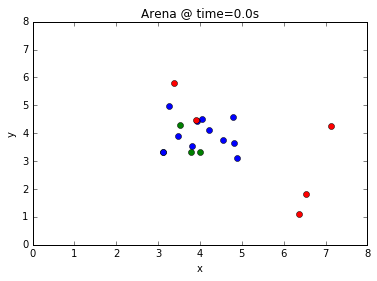

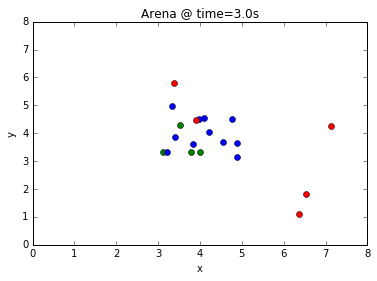

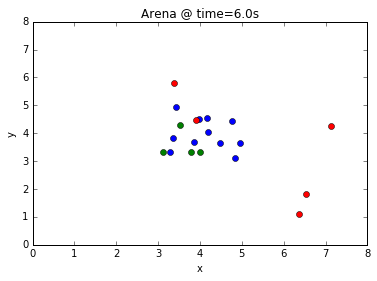

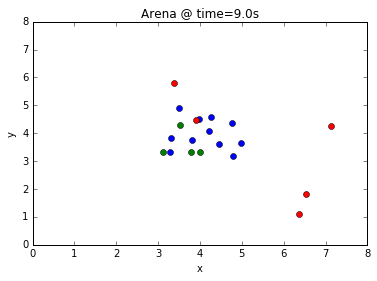

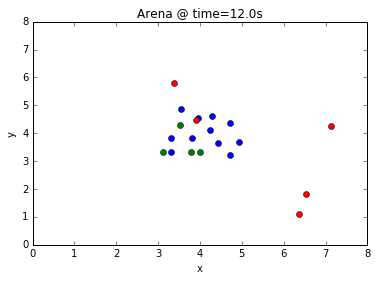

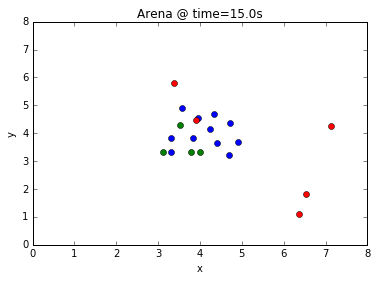

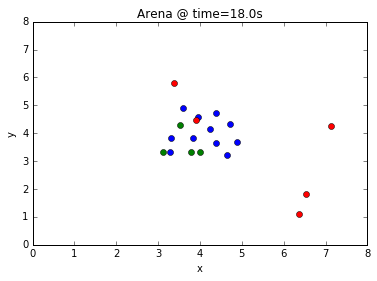

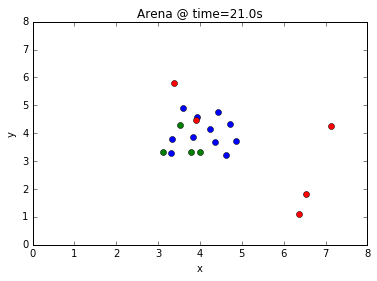

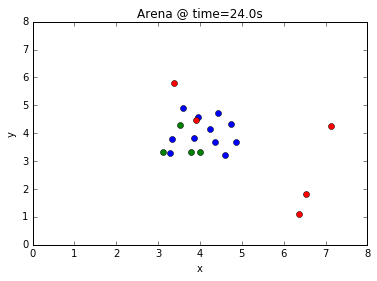

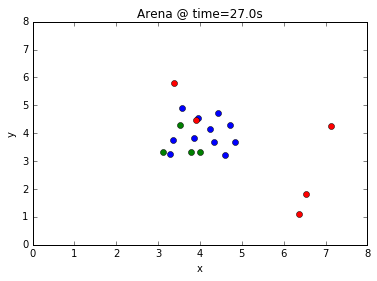

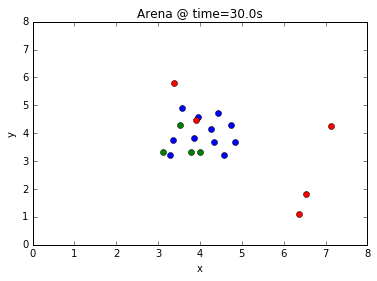

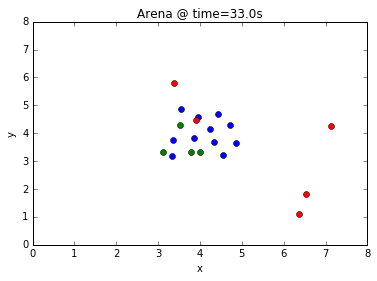

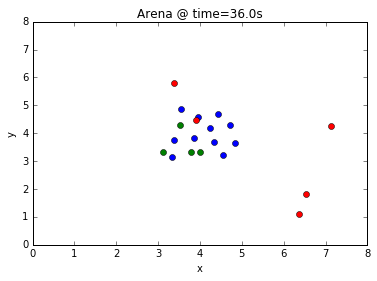

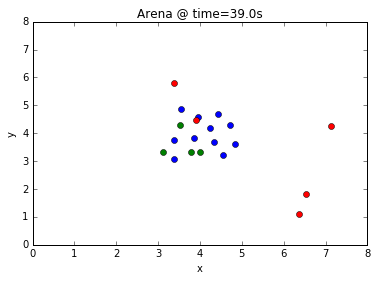

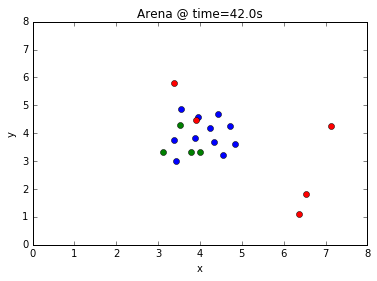

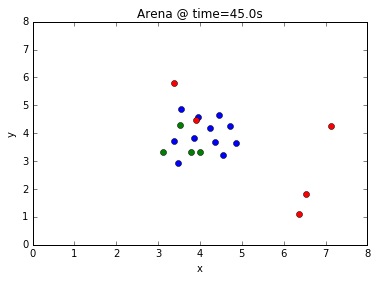

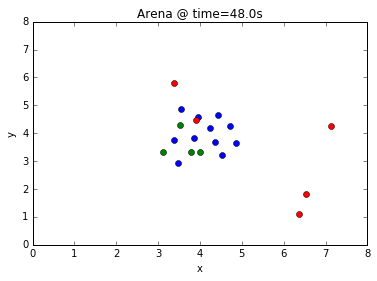

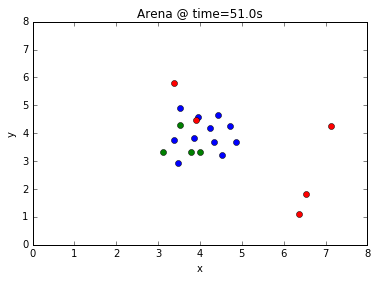

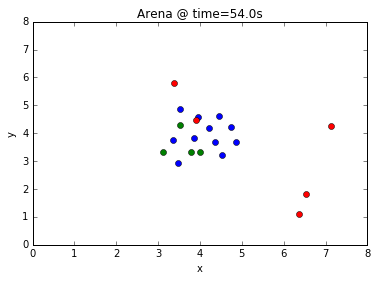

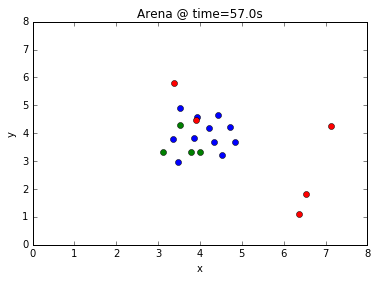

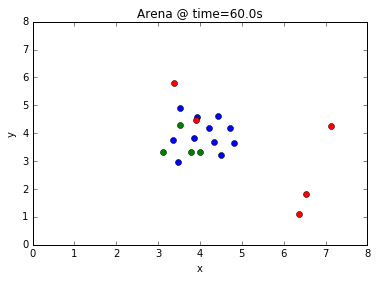

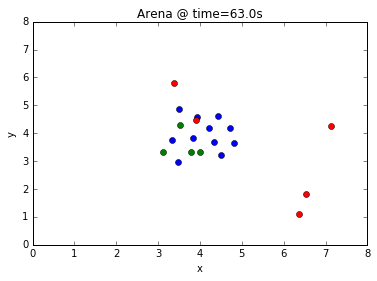

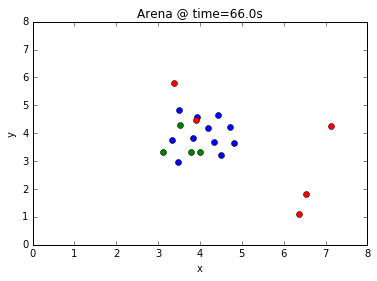

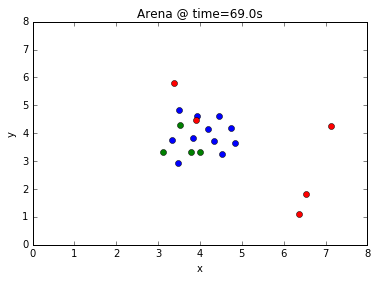

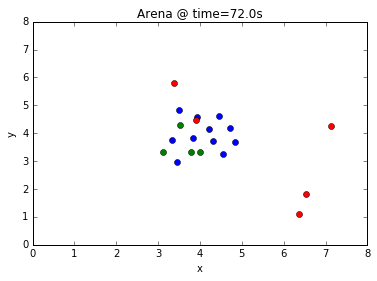

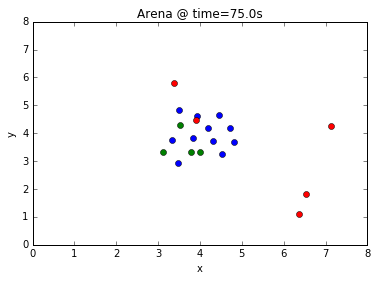

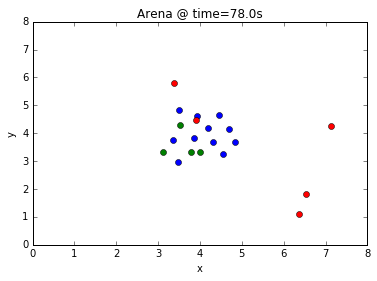

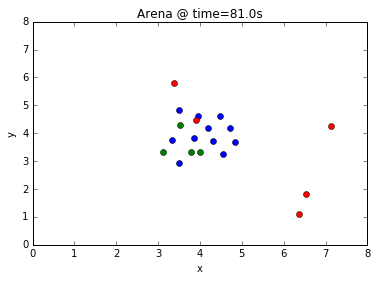

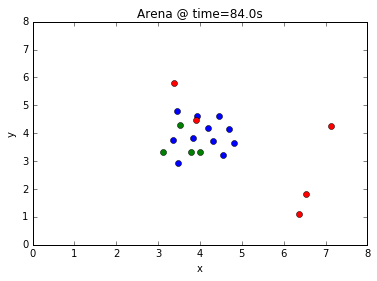

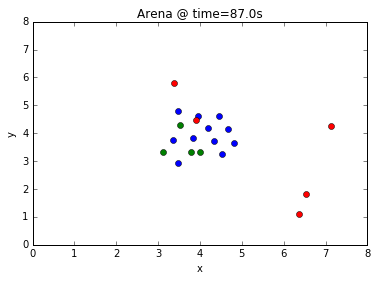

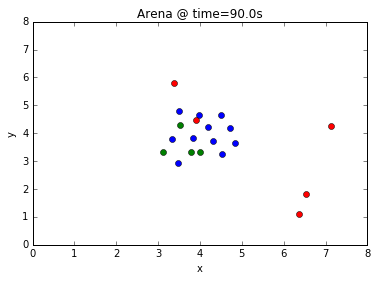

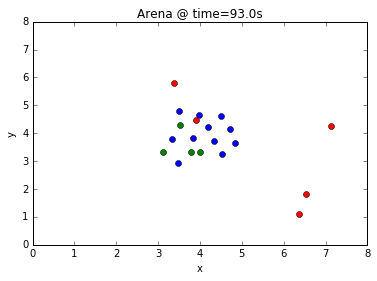

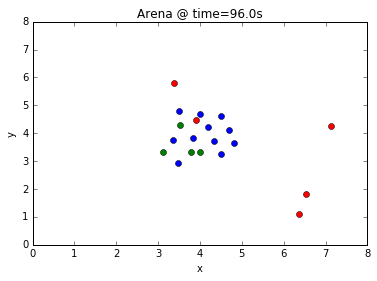

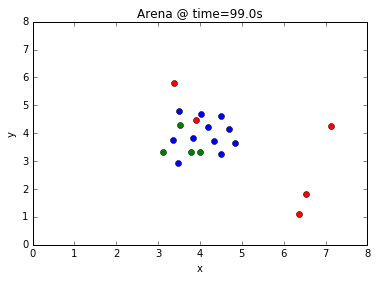

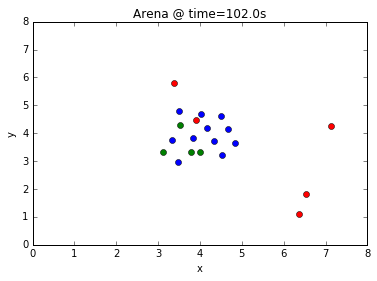

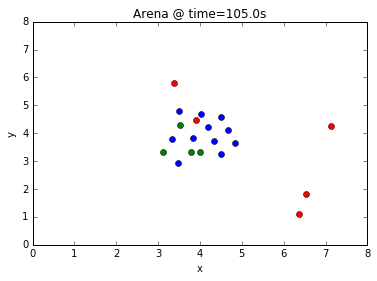

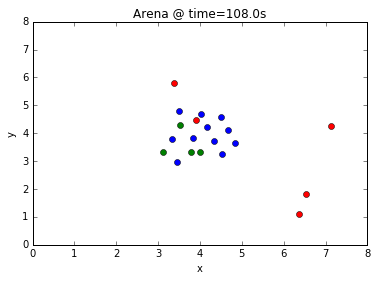

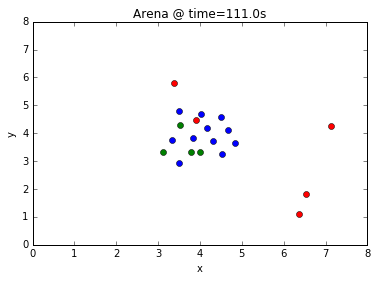

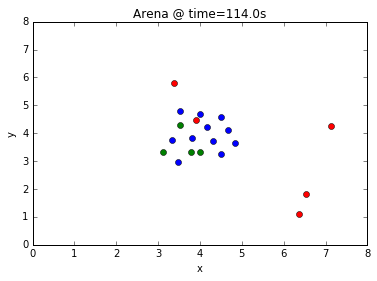

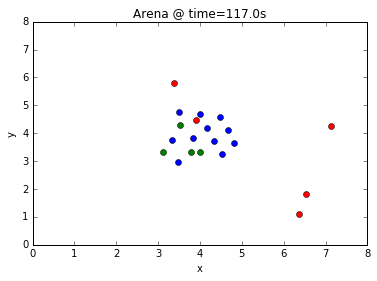

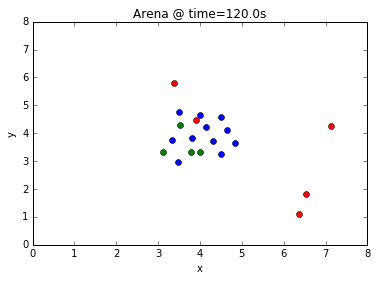

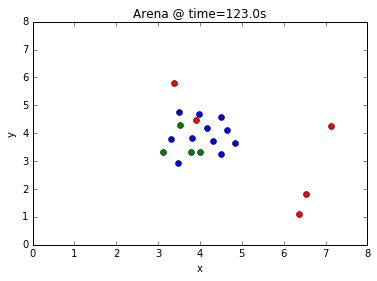

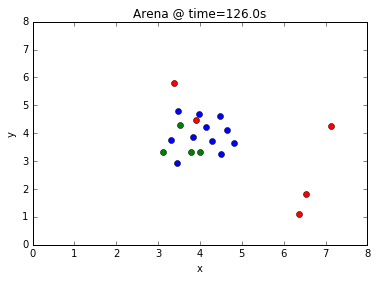

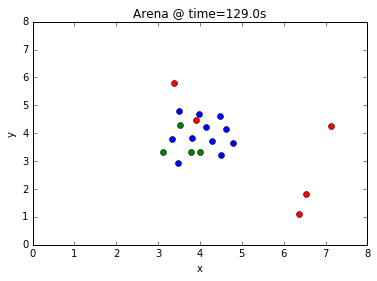

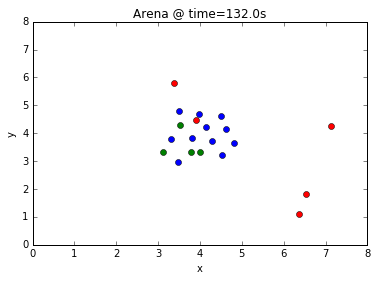

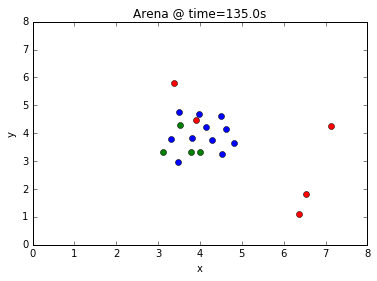

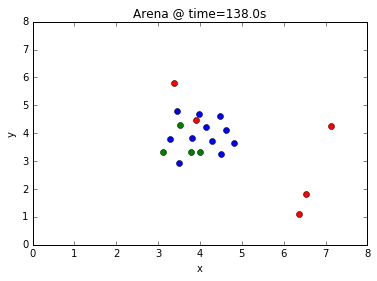

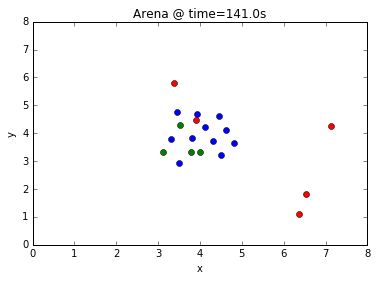

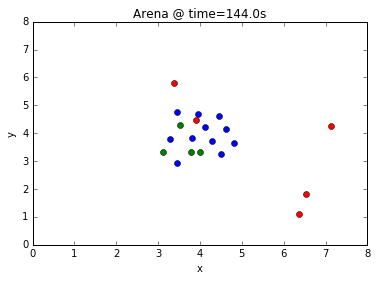

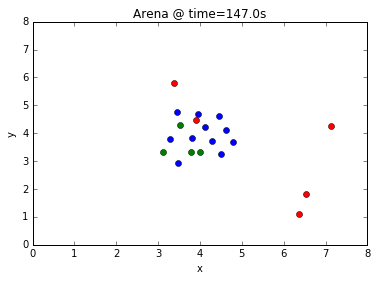

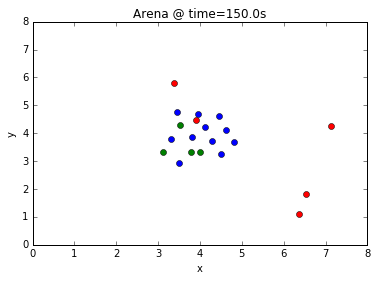

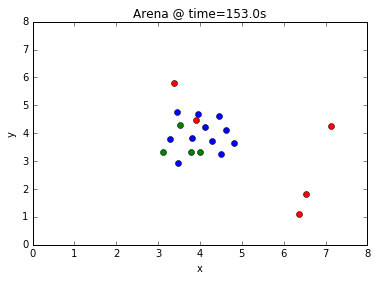

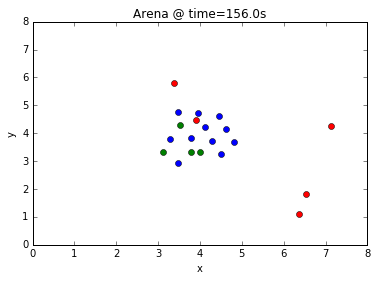

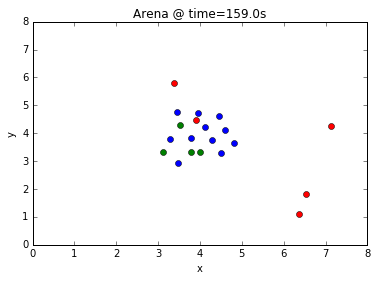

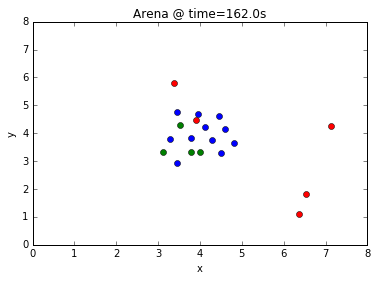

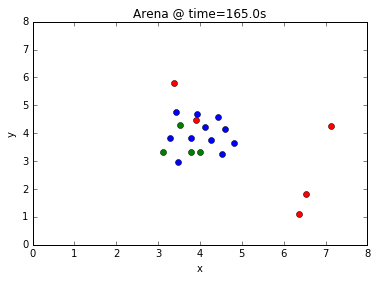

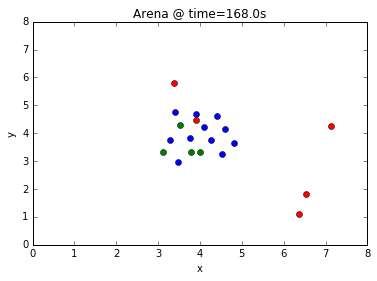

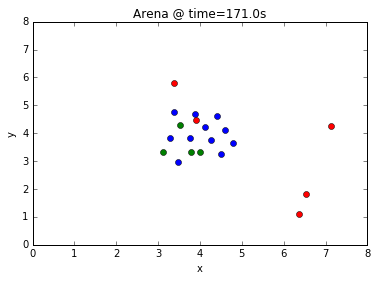

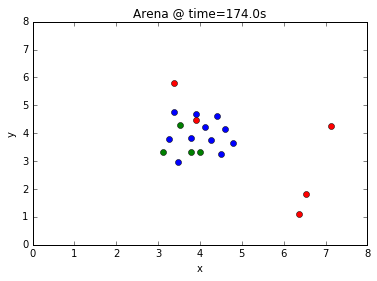

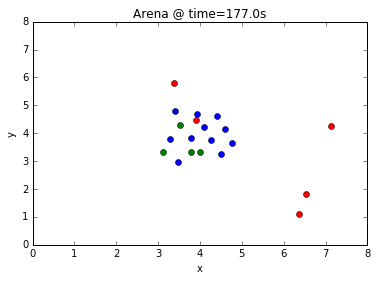

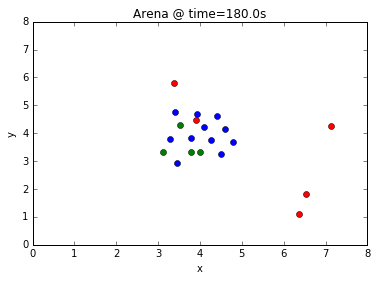

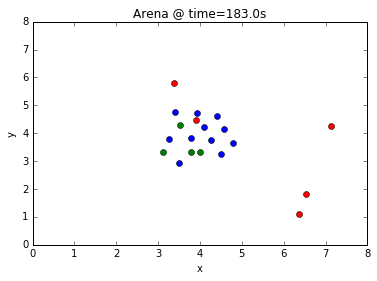

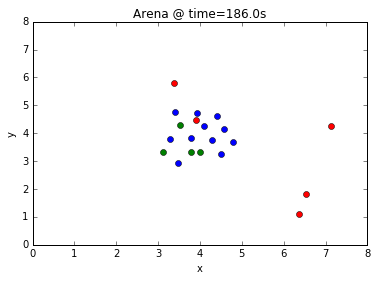

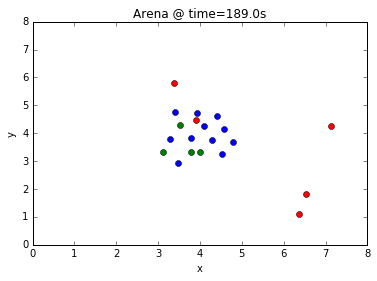

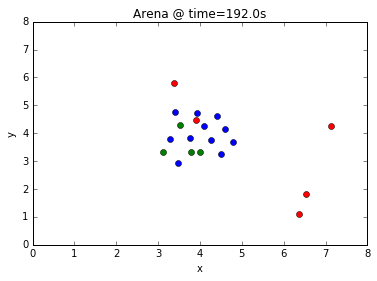

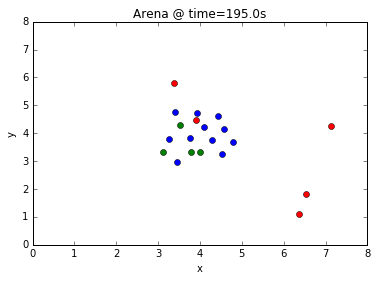

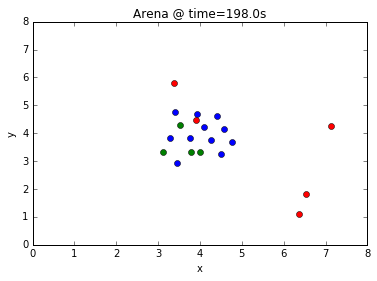

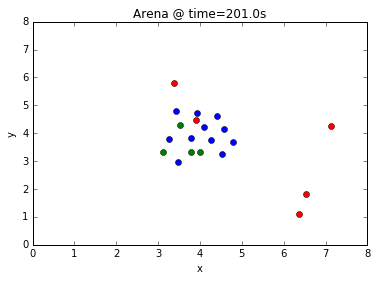

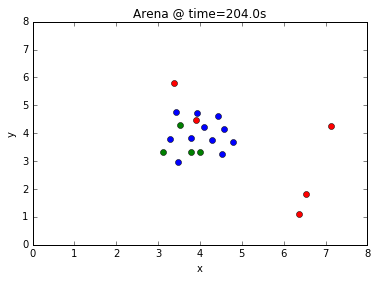

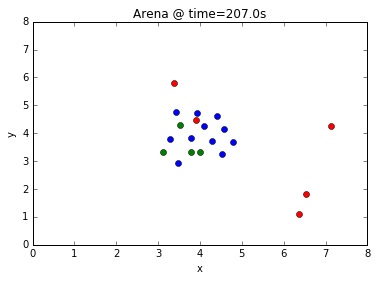

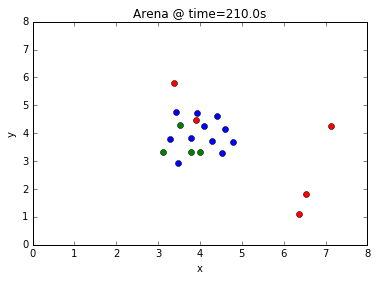

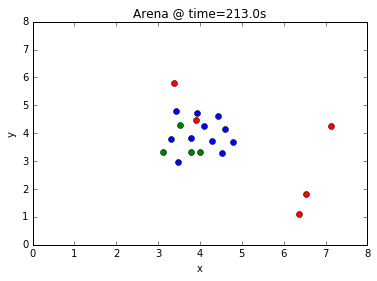

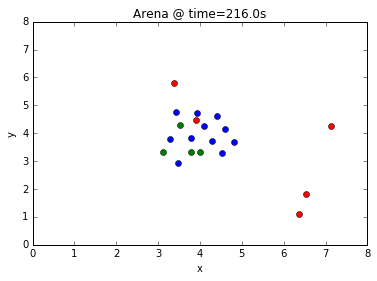

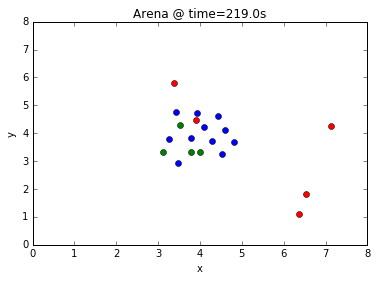

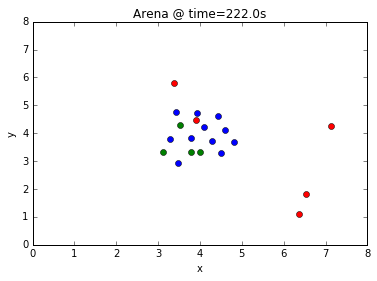

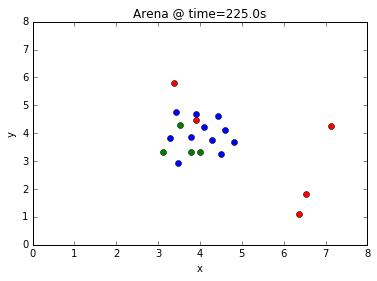

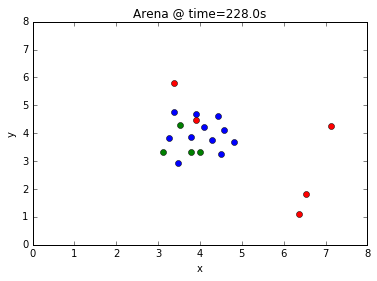

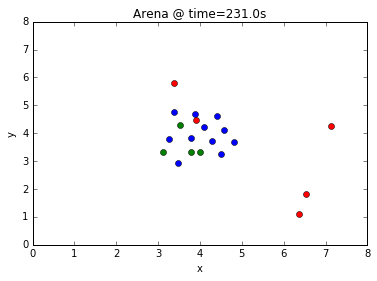

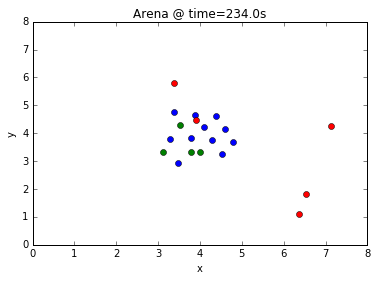

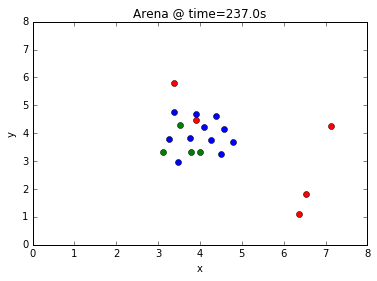

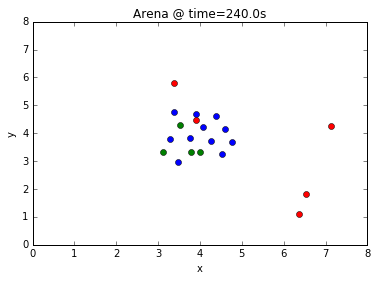

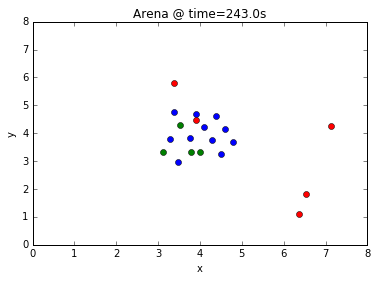

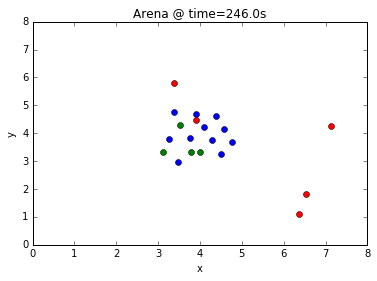

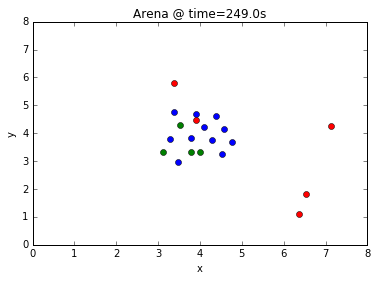

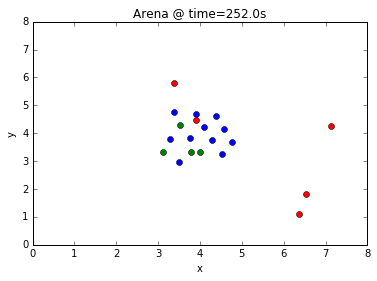

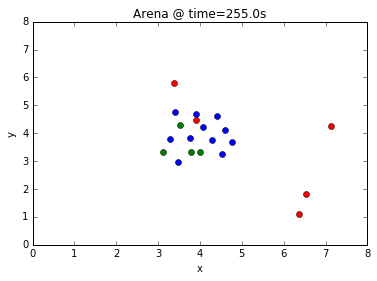

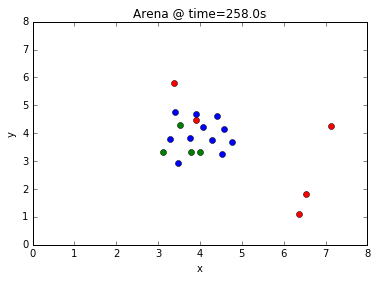

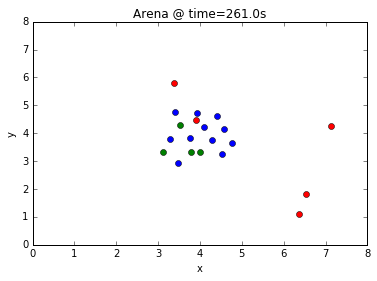

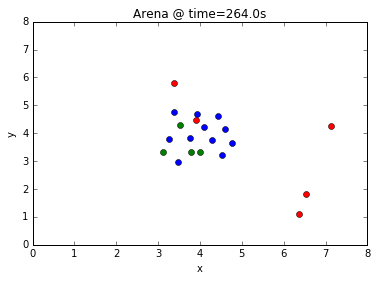

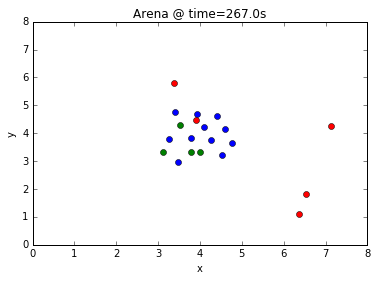

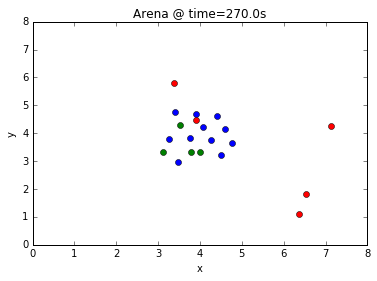

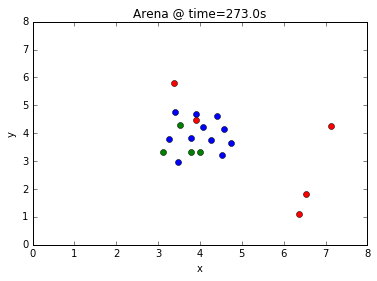

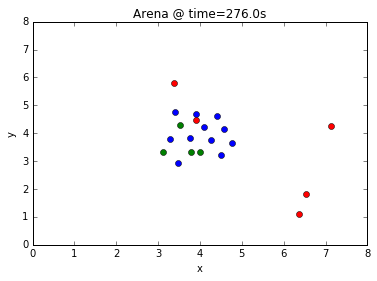

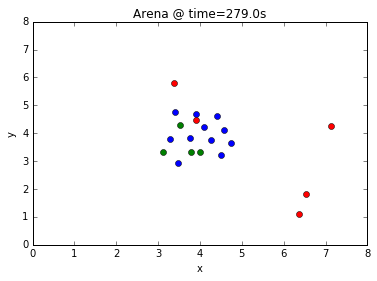

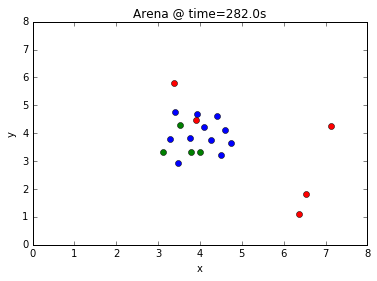

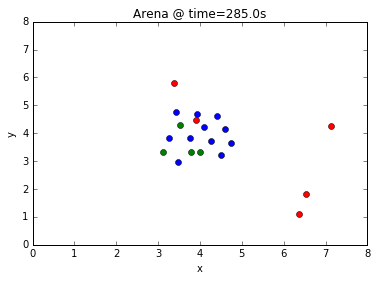

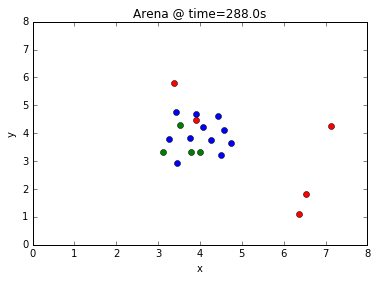

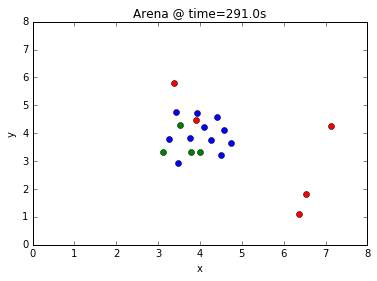

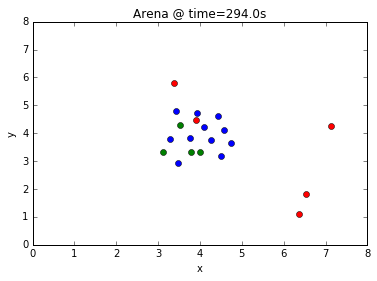

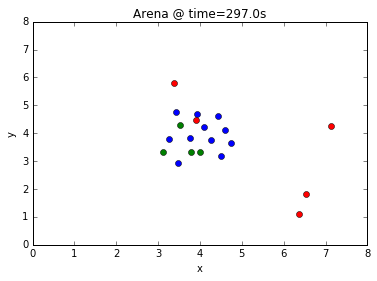

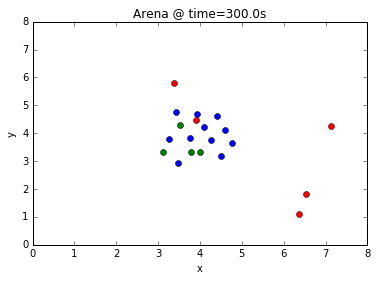

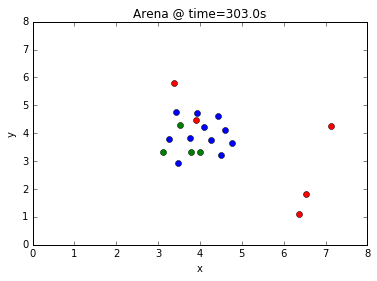

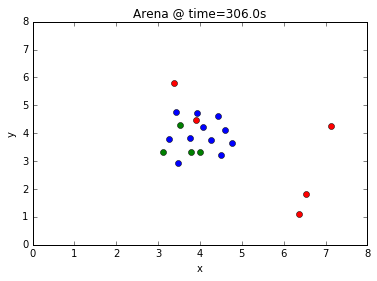

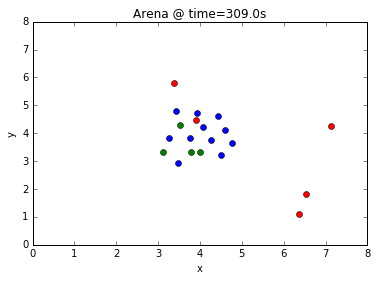

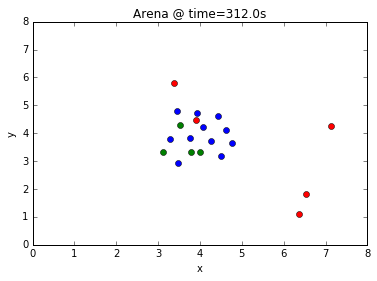

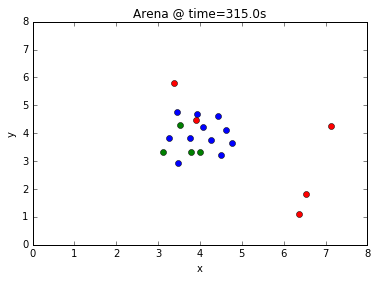

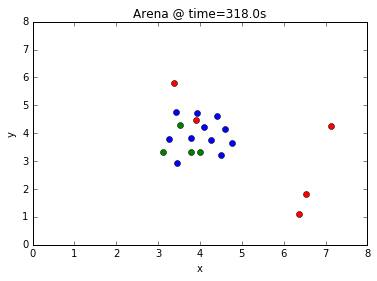

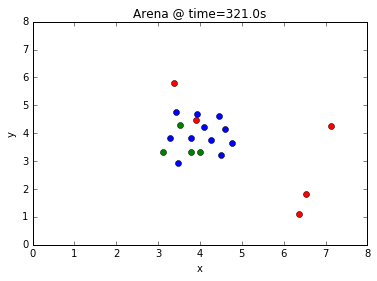

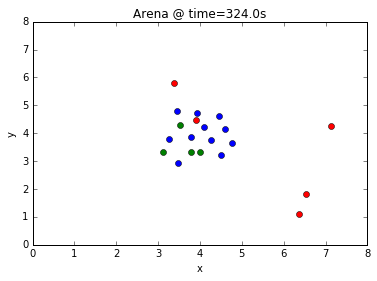

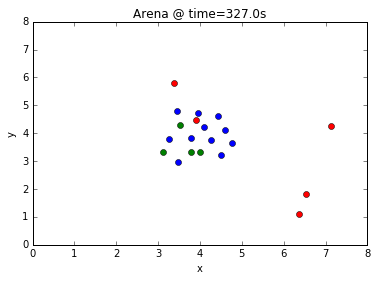

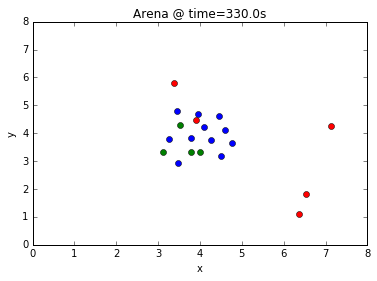

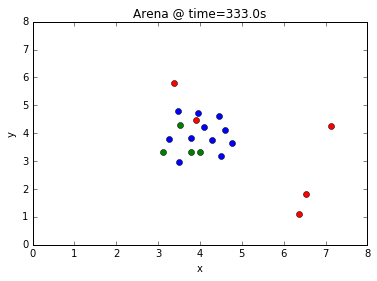

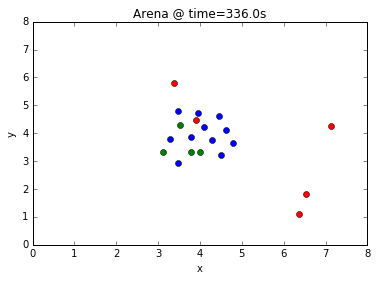

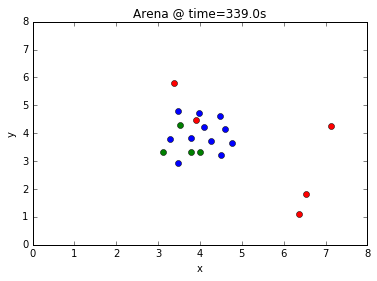

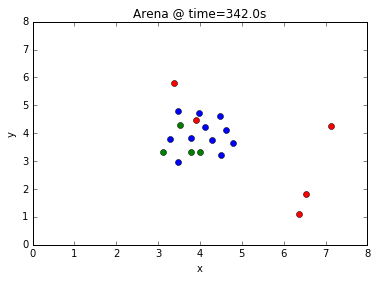

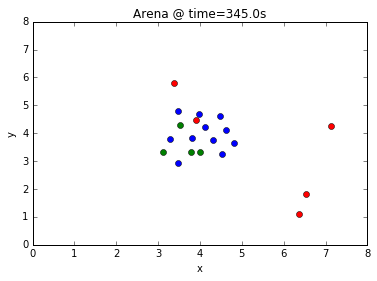

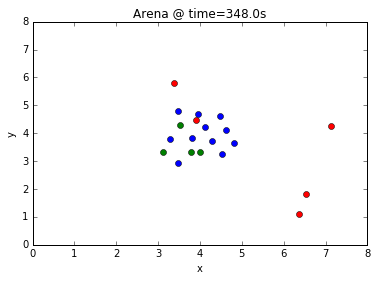

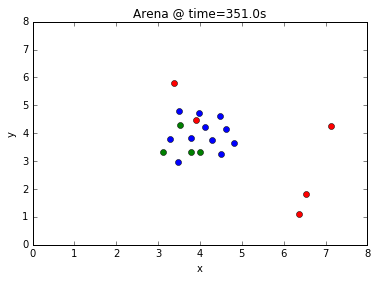

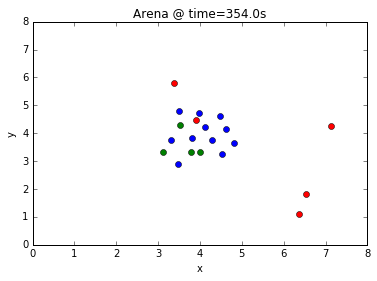

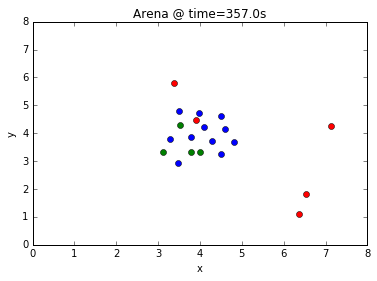

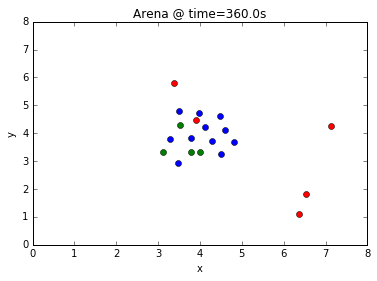

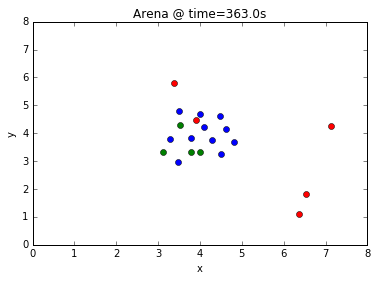

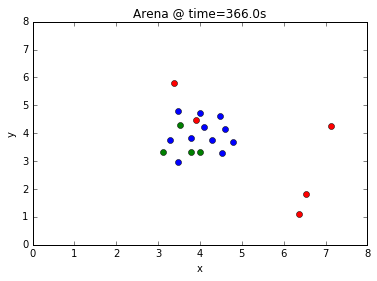

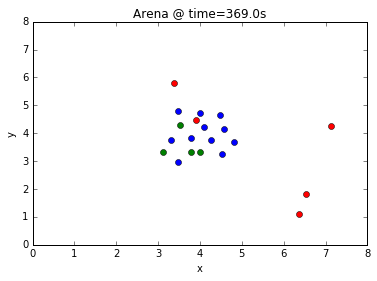

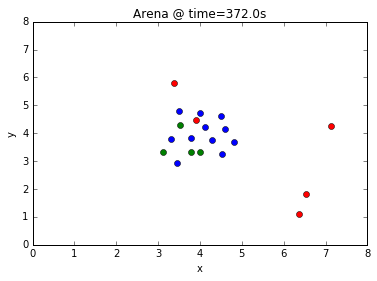

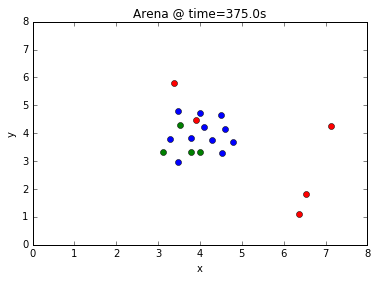

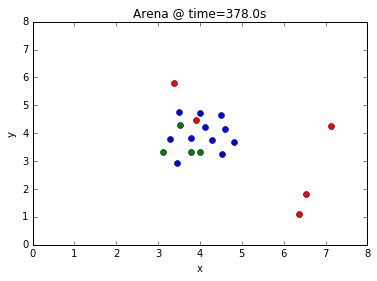

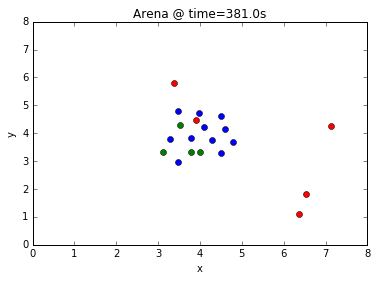

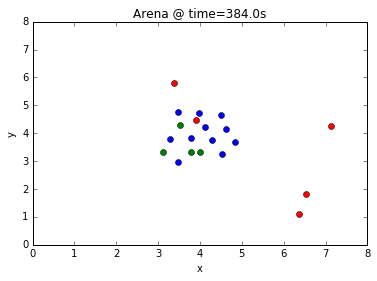

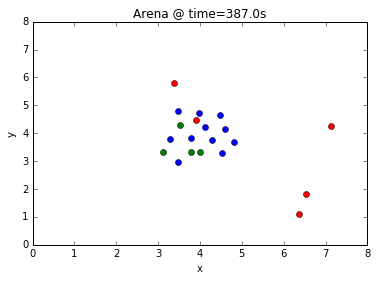

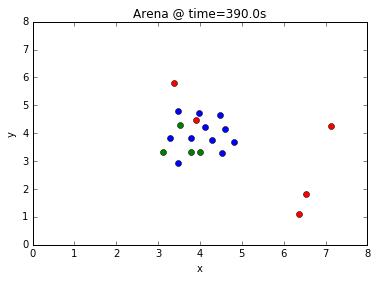

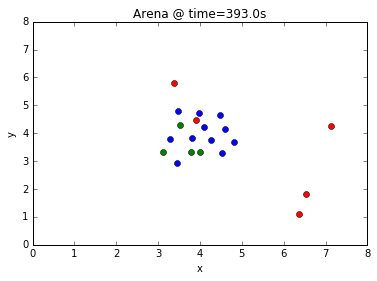

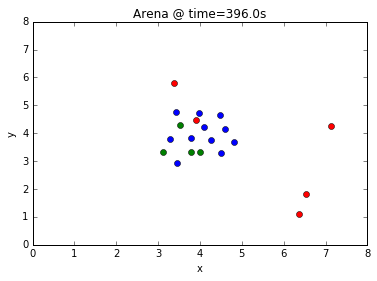

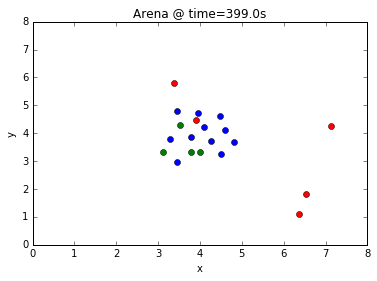

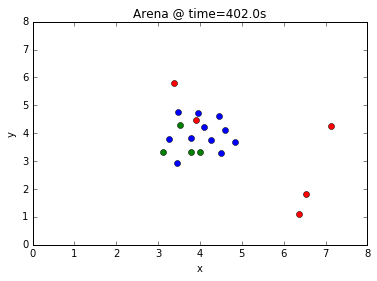

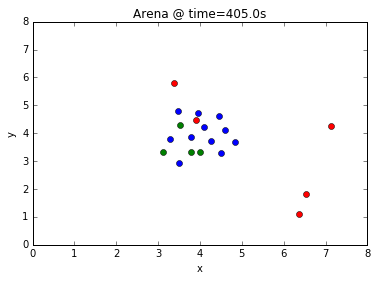

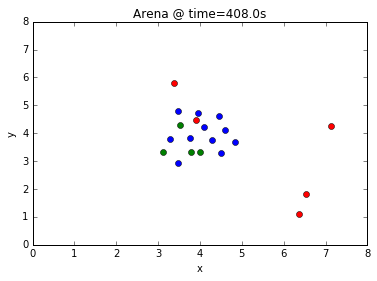

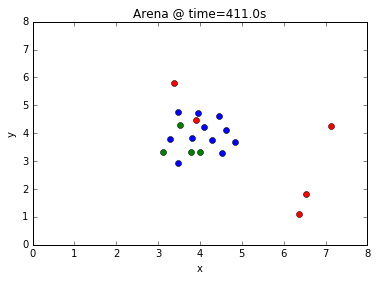

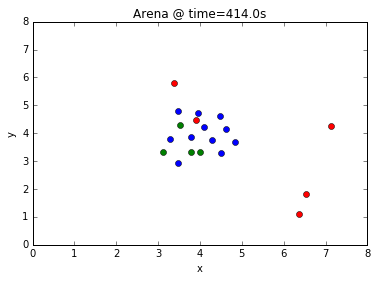

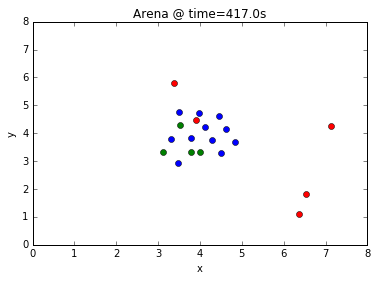

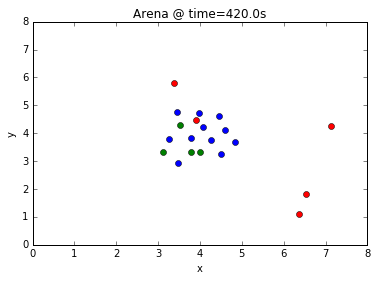

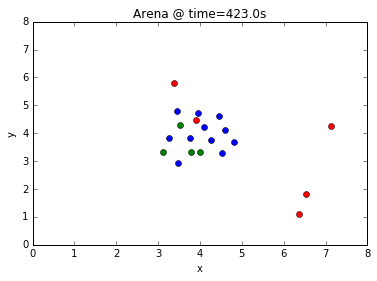

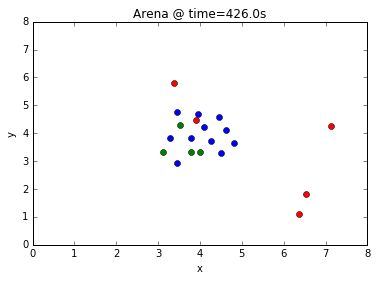

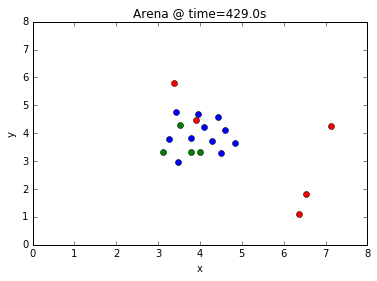

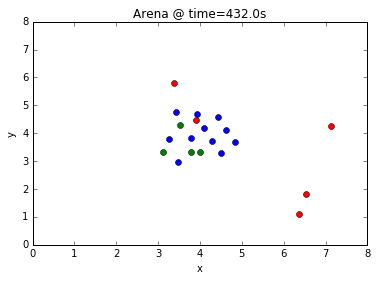

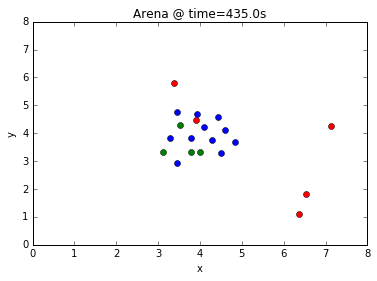

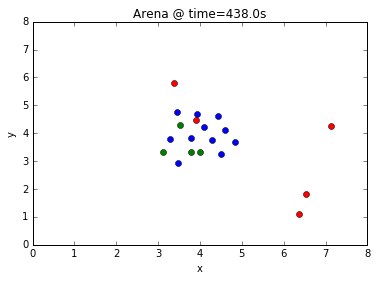

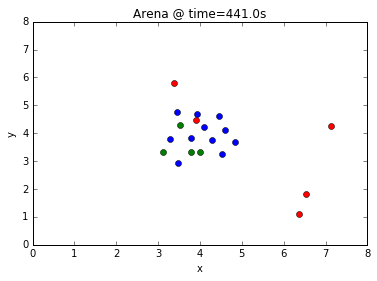

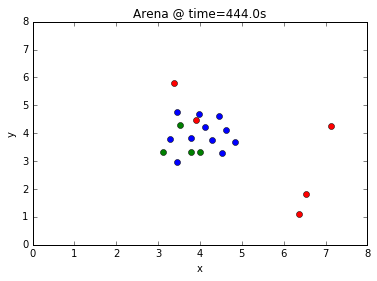

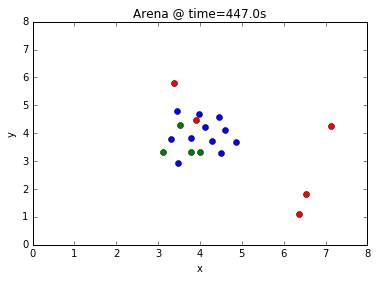

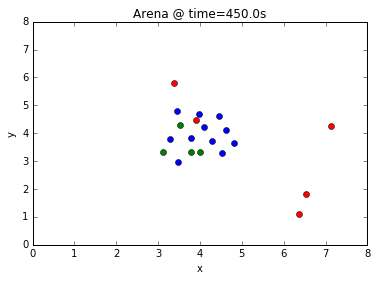

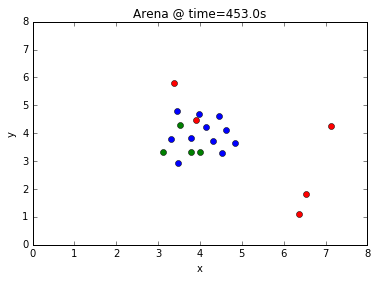

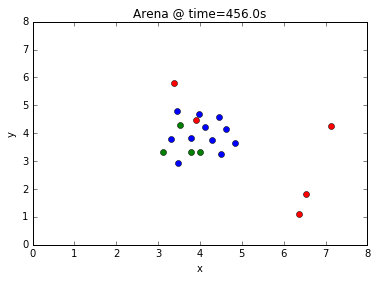

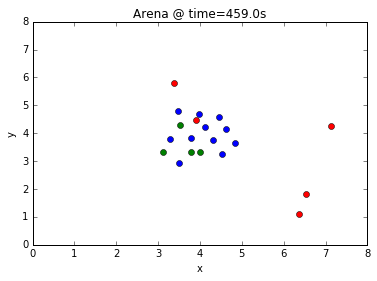

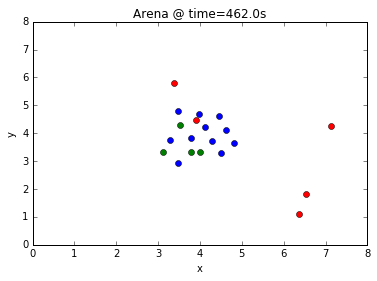

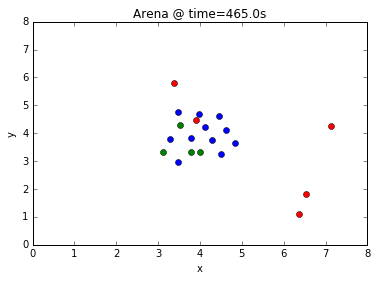

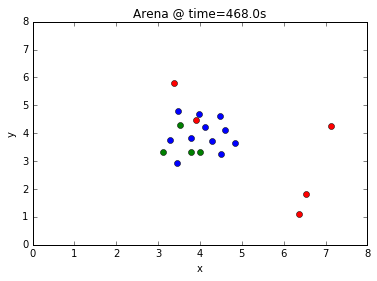

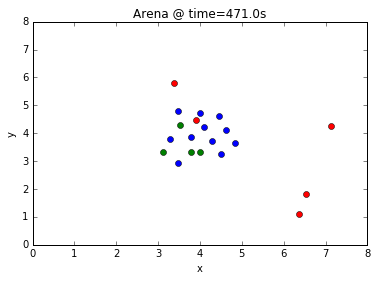

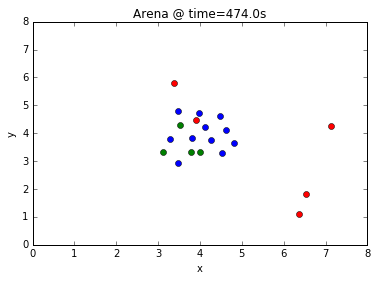

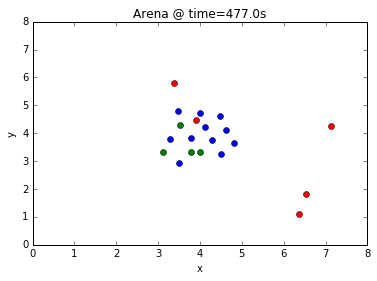

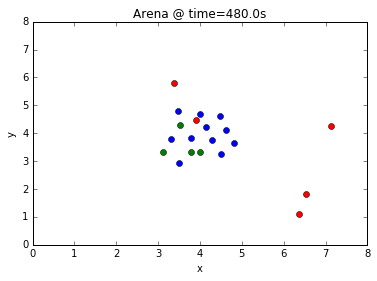

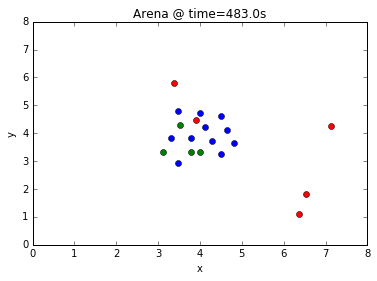

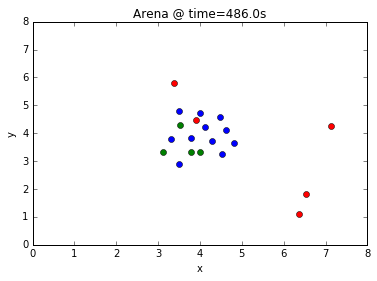

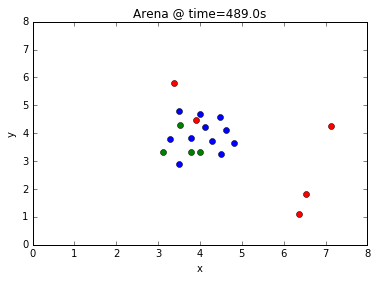

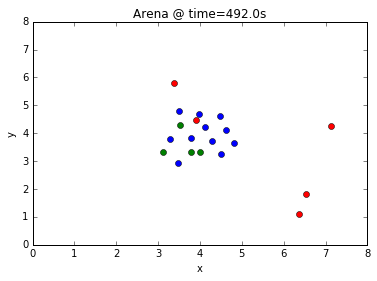

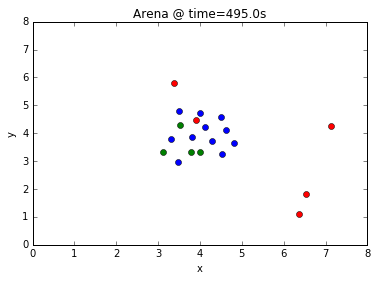

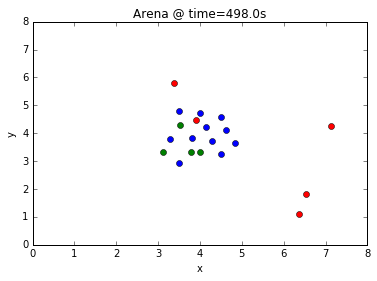

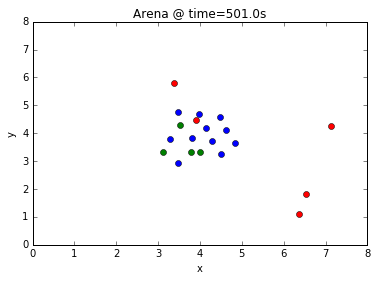

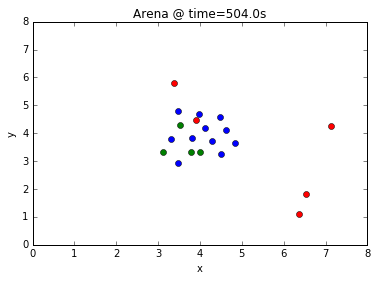

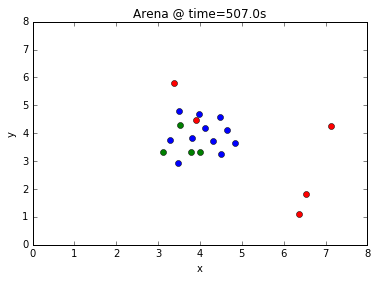

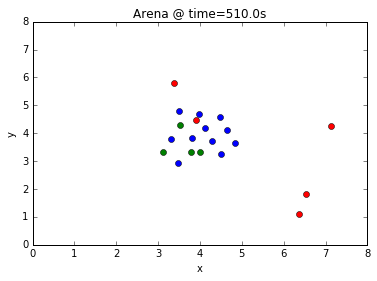

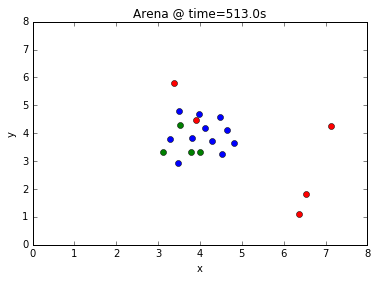

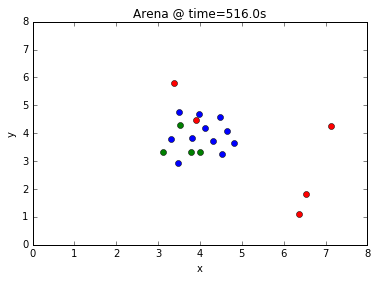

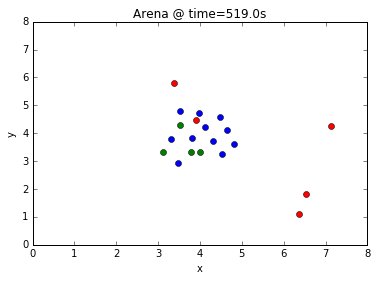

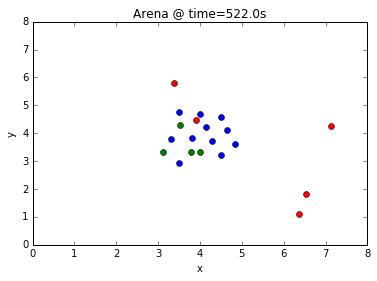

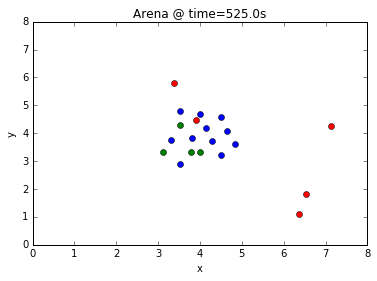

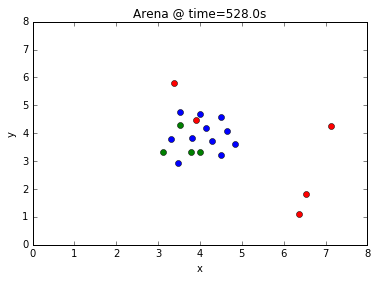

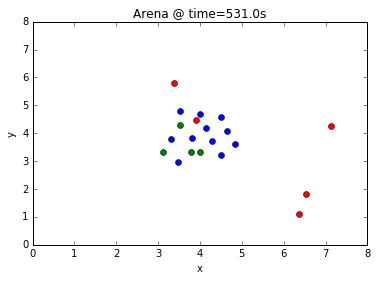

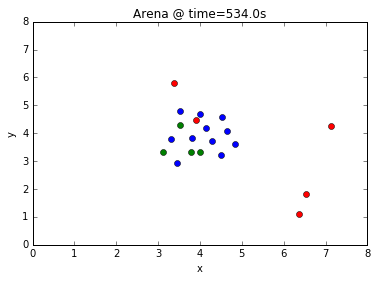

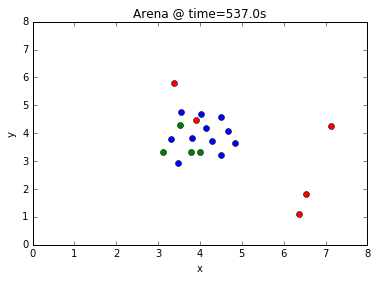

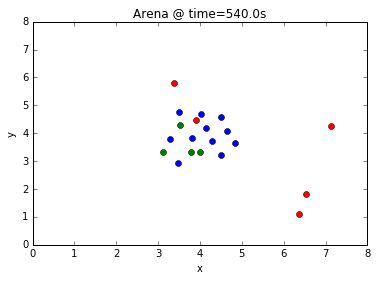

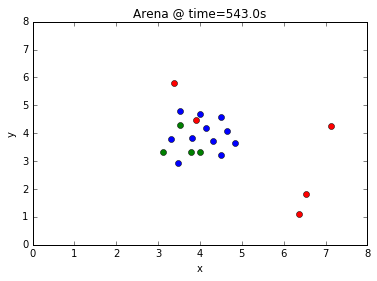

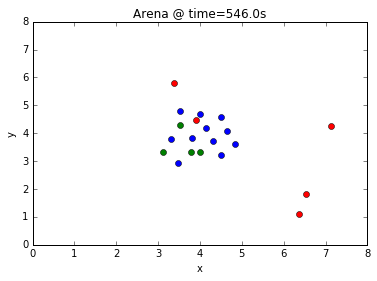

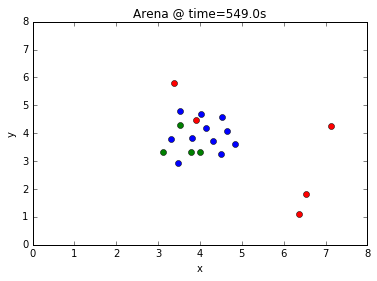

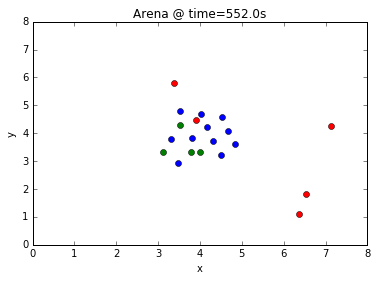

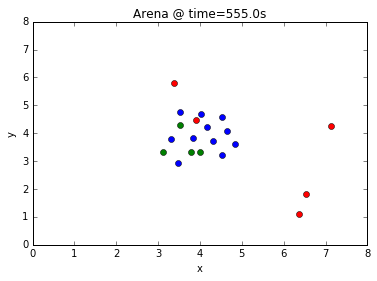

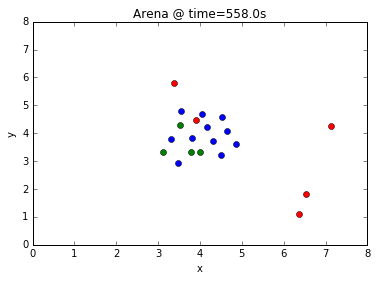

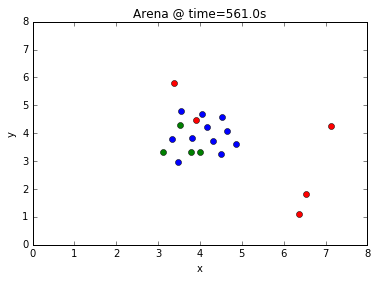

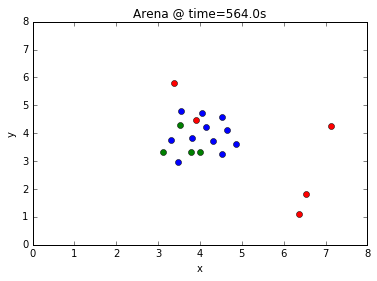

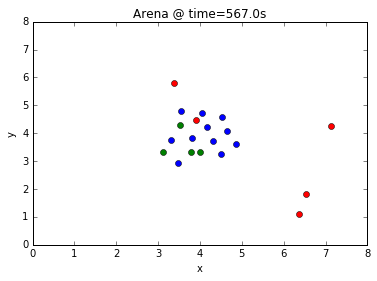

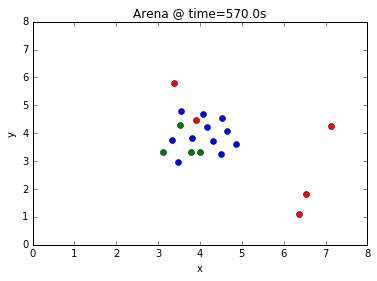

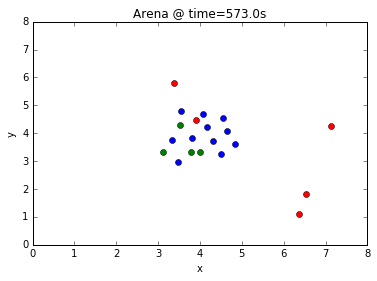

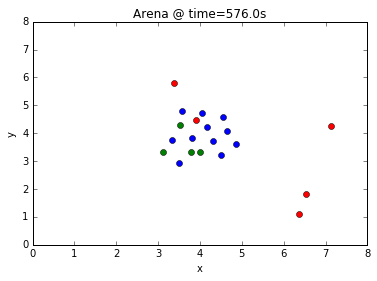

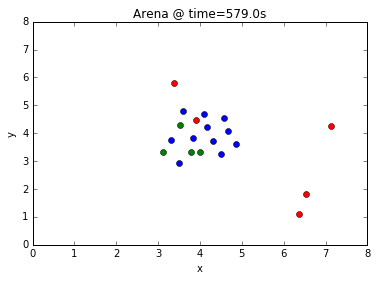

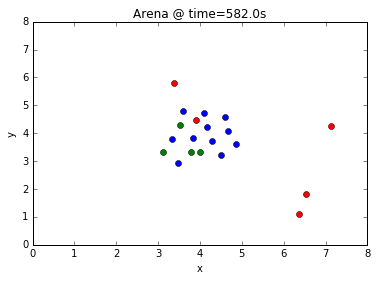

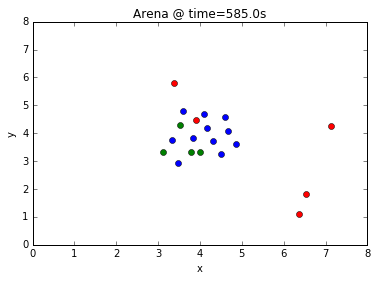

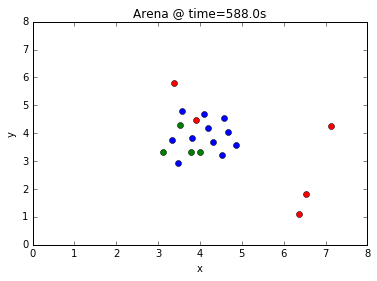

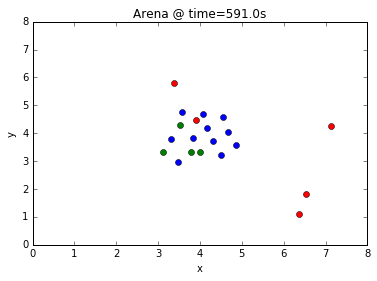

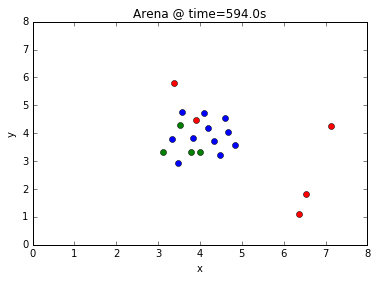

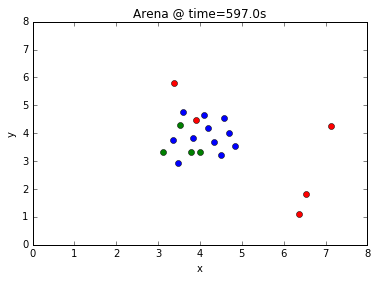

In [109]:
init()
l_mapping()

for t in range(0,int(H/propagation)):
    seconds = t*propagation
    A = neighbors()
    
    #####################
    #manage communication
    #####################
    
    communicate(A,t)
    update_thickness_info(A)
    
    #####################
    #####################
    
    if seconds%control==0:
        
        ###############
        #manage control
        ###############
        
        ovelocities = velocities             #save old velocities
        velocities = np.zeros((N, 2))        #reset the velocities vector
        bb_i(A,ovelocities)                  #BASE BEHAVIOR I
        #bb_ii(A)                             #BASE BEHAVIOR II
        #bb_iii()                             #BASE BEHAVIOR III
        
        #ovelocities = velocities             #save old velocities
        #velocities = np.zeros((N, 2))        #reset the velocities vector
        #lfs(A,ovelocities)                   #LEADER FORCES
        
        #ovelocities = velocities             #save old velocities
        #velocities = np.zeros((N, 2))        #reset the velocities vector
        #density(A,ovelocities)               #DENSITY CORRECTION
        
        #ovelocities = velocities              #save old velocities
        #velocities = np.zeros((N, 2))         #reset the velocities vector
        #barycenter(A,ovelocities)             #BARYCENTER CORRECTION
        
        ##ovelocities = velocities             #save old velocities
        ##velocities = np.zeros((N, 2))        #reset the velocities vector
        ##thickness(A,ovelocities)             #THICKNESS CONTRACTION
        
        #######################
        #map leaders to targets (possibly overwrite leaders' velocities)
        #######################
        
        #leaderstotargets()
        
        ###############
        ###############
        
    positions = update()                     #move the robots AT EVERY STEP OF THE SIMULATION
    
    if seconds%plot_sampling==0:             #plot
        display(seconds)

In [110]:
#tail
print('Thanks for watching!')

Thanks for watching!
